# Pairwise cosine similarity

In [11]:
import json
from scipy.spatial.distance import cosine
import numpy as np


def load_data(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


def organize_data(data):
    organized_data = {"enclosed space": {}, "interior passage": {}, "exterior open": {}}
    for item in data:
        space_type = item["type"]
        building = item["bldg"]
        feature = np.array(item["feature"]).reshape(1, -1)
        if building not in organized_data[space_type]:
            organized_data[space_type][building] = []
        organized_data[space_type][building].append(feature)
    return organized_data


def calculate_pairwise_similarity(organized_data):
    comparison_results = {}
    for space_type, buildings in organized_data.items():
        iim_features = buildings["iim"]
        comparison_results[space_type] = {}
        for building, features in buildings.items():
            if building != "iim":
                distances = []
                for iim_feature in iim_features:
                    for feature in features:
                        iim_feature = iim_feature.flatten()
                        feature = feature.flatten()
                        distance = cosine(iim_feature, feature)
                        distances.append(distance)
                average_distance = sum(distances) / len(distances)
                comparison_results[space_type][building] = average_distance
    return comparison_results

In [23]:
data = load_data("./log_tmp/dataset1116.json")
organized_data = organize_data(data)
similarity_results = calculate_pairwise_similarity(organized_data)

print(similarity_results)

{'enclosed space': {'caracalla': 0.7604592942307923, 'demo': 0.4974160751408573, 'pantheon': 0.7376111935295331, 'trajan': 0.45791467006305203}, 'interior passage': {'demo': 0.2381350069817054, 'caracalla': 0.4240875151272634, 'trajan': 1.217553524625595, 'pantheon': 0.6292636373145737}, 'exterior open': {'pantheon': 0.1564697483395594, 'demo': 0.5552689085043782, 'trajan': 0.20219494130089602, 'caracalla': 0.08910491766058418}}


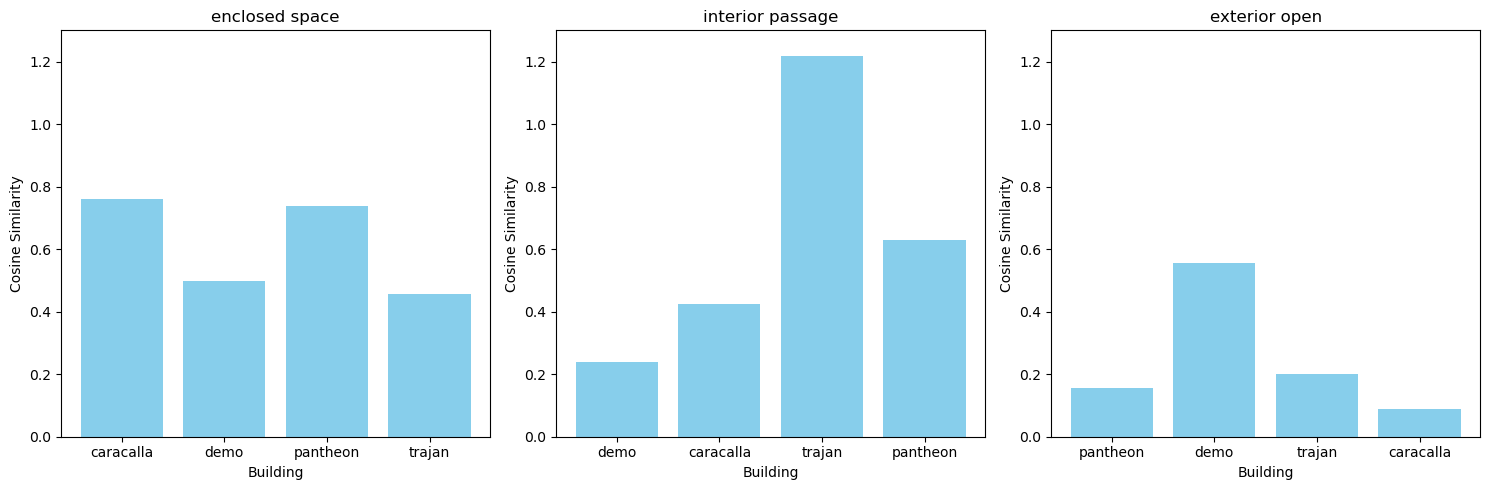

In [24]:
import matplotlib.pyplot as plt

# Creating three separate plots for each space type
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (space_type, similarities) in enumerate(similarity_results.items()):
    buildings = list(similarities.keys())
    values = list(similarities.values())

    axes[i].bar(buildings, values, color="skyblue")
    axes[i].set_title(space_type)
    axes[i].set_xlabel("Building")
    axes[i].set_ylabel("Cosine Similarity")
    axes[i].set_ylim(0, 1.3)  # Adjusting y-axis limits for better visualization

# Adjusting layout for better visualization
plt.tight_layout()
plt.show()

# Nearest Neighbor

In [14]:
from scipy.spatial.distance import cdist


def calculate_nearest_neighbors(organized_data):
    nn_results = {}
    for space_type, buildings in organized_data.items():
        iim_features = np.array(buildings["iim"])
        nn_results[space_type] = {}
        for building, features in buildings.items():
            if building != "iim":
                building_features = np.array(features)
                # Calculate distances to nearest neighbor
                iim_features = iim_features.reshape(-1, 256)
                building_features = building_features.reshape(-1, 256)
                distances = cdist(iim_features, building_features, metric="cosine")
                min_distances = np.min(distances, axis=1)
                average_distance = np.mean(min_distances)
                nn_results[space_type][building] = average_distance
    return nn_results

In [15]:
nn_results = calculate_nearest_neighbors(organized_data)
print(nn_results)

{'enclosed space': {'pantheon': 0.12277730551010928, 'caracalla': 0.5508903511862827, 'standard': 0.8264217250685614, 'trajan': 0.3368939431113428}, 'interior passage': {'caracalla': 0.5587112312692049, 'standard': 0.3984415054208894, 'pantheon': 0.3499586957935824, 'trajan': 0.12290953865078429}, 'exterior open': {'standard': 0.8718790638082645, 'pantheon': 0.571450577170065, 'caracalla': 0.4271446358841462, 'trajan': 0.4127300044379143}}


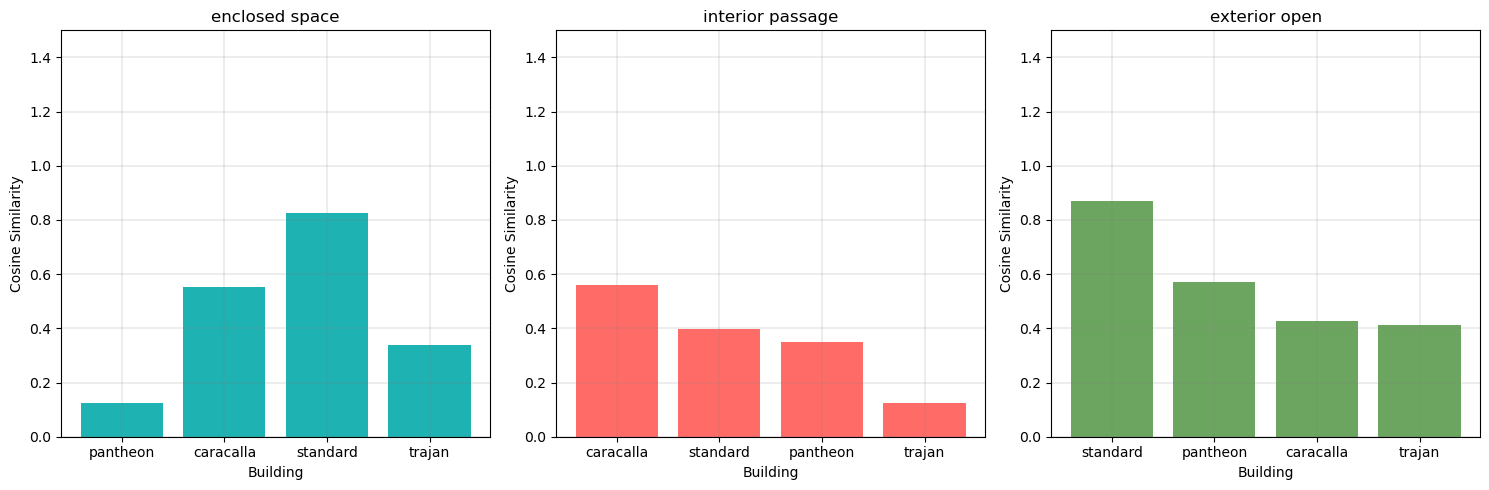

In [16]:
# Creating three separate plots for each space type
colors = {
    "enclosed space": "#1fb2b2",
    "interior passage": "#ff6c68",
    "exterior open": "#6ca55f",
}
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (space_type, similarities) in enumerate(nn_results.items()):
    buildings = list(similarities.keys())
    values = list(similarities.values())
    # Enable the grid on major ticks
    axes[i].grid(which="major", linestyle="-", linewidth="0.2", color="gray")
    axes[i].grid(which="minor", linestyle="--", linewidth="0.2", color="gray")
    # Plot bars
    axes[i].bar(buildings, values, color=colors[space_type])

    # Set title and labels
    axes[i].set_title(space_type)
    axes[i].set_xlabel("Building")
    axes[i].set_ylabel("Cosine Similarity")

    # Set y-axis limits
    axes[i].set_ylim(0, 1.5)

    # Set the location of the major ticks at the center of each bar
    axes[i].set_xticks(range(len(buildings)), minor=False)
    axes[i].set_xticklabels(buildings, minor=False)

    # Optionally, set minor ticks if you want to customize their appearance
    # axes[i].set_xticks([x + 0.5 for x in range(len(buildings))], minor=True)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Normal Heatmap

c:\Users\moumo\anaconda3\envs\dsm\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior

c:\Users\moumo\anaconda3\envs\dsm\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior

c:\Users\moumo\anaconda3\envs\dsm\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



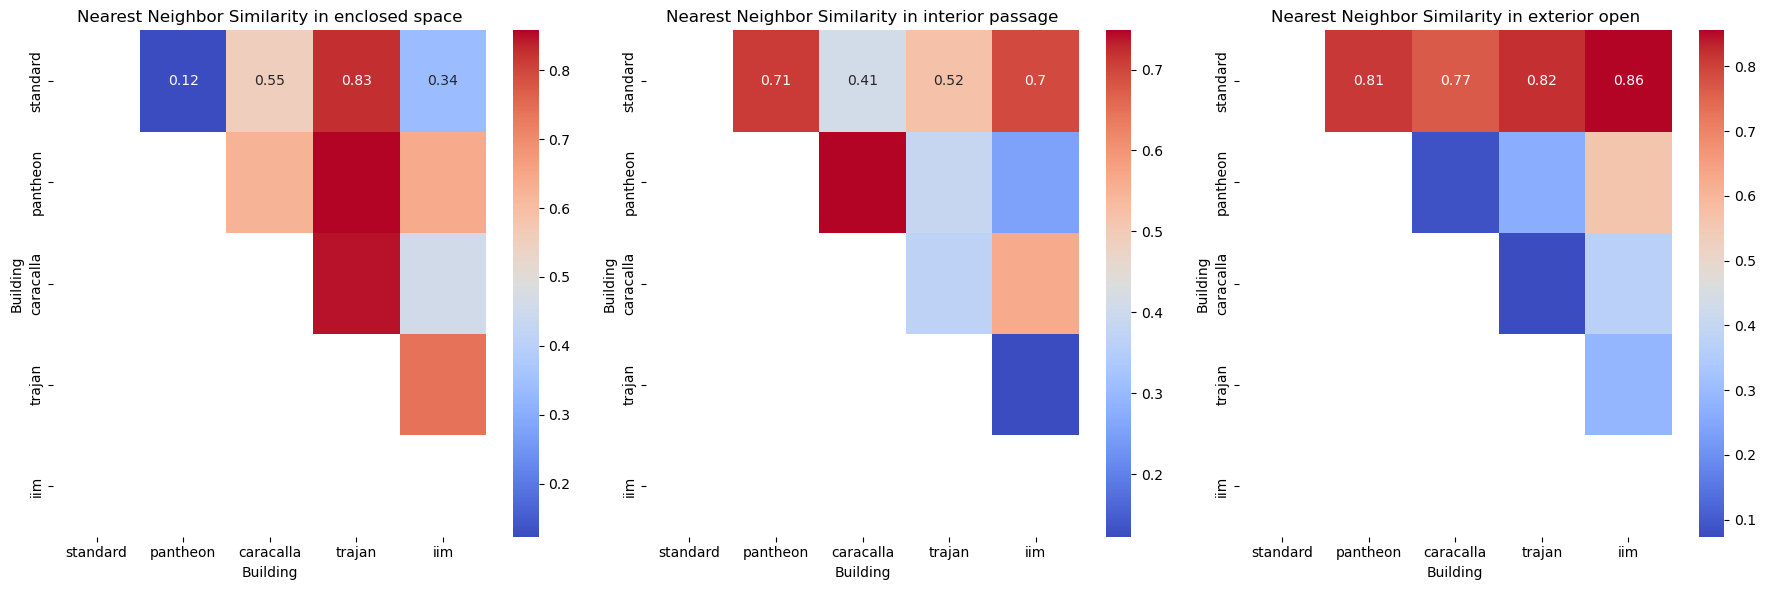

In [17]:
import seaborn as sns


def calculate_similarity_matrix(data):
    similarity_matrix = {}
    for space_type, buildings in data.items():
        building_names = list(buildings.keys())
        matrix = np.zeros((len(building_names), len(building_names)))

        for i, building_i in enumerate(building_names):
            for j, building_j in enumerate(building_names):
                if i != j:
                    distances = cdist(
                        np.array(buildings[building_i]).reshape(-1, 256),
                        np.array(buildings[building_j]).reshape(-1, 256),
                        metric="cosine",
                    )
                    matrix[i, j] = np.mean(np.min(distances, axis=1))
                else:
                    matrix[i, j] = 0

        similarity_matrix[space_type] = matrix

    return similarity_matrix, building_names


# Replace organized_data with your actual organized data
similarity_matrices, building_names = calculate_similarity_matrix(organized_data)

# Plotting the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (space_type, matrix) in enumerate(similarity_matrices.items()):
    # Mask for the lower triangle
    mask = np.tril(np.ones_like(matrix, dtype=bool))

    sns.heatmap(
        matrix,
        mask=mask,
        ax=axes[i],
        annot=True,
        cmap="coolwarm",
        xticklabels=building_names,
        yticklabels=building_names,
    )
    axes[i].set_title(f"Nearest Neighbor Similarity in {space_type}")
    axes[i].set_xlabel("Building")
    axes[i].set_ylabel("Building")

plt.tight_layout()
plt.show()

# circle bubble 

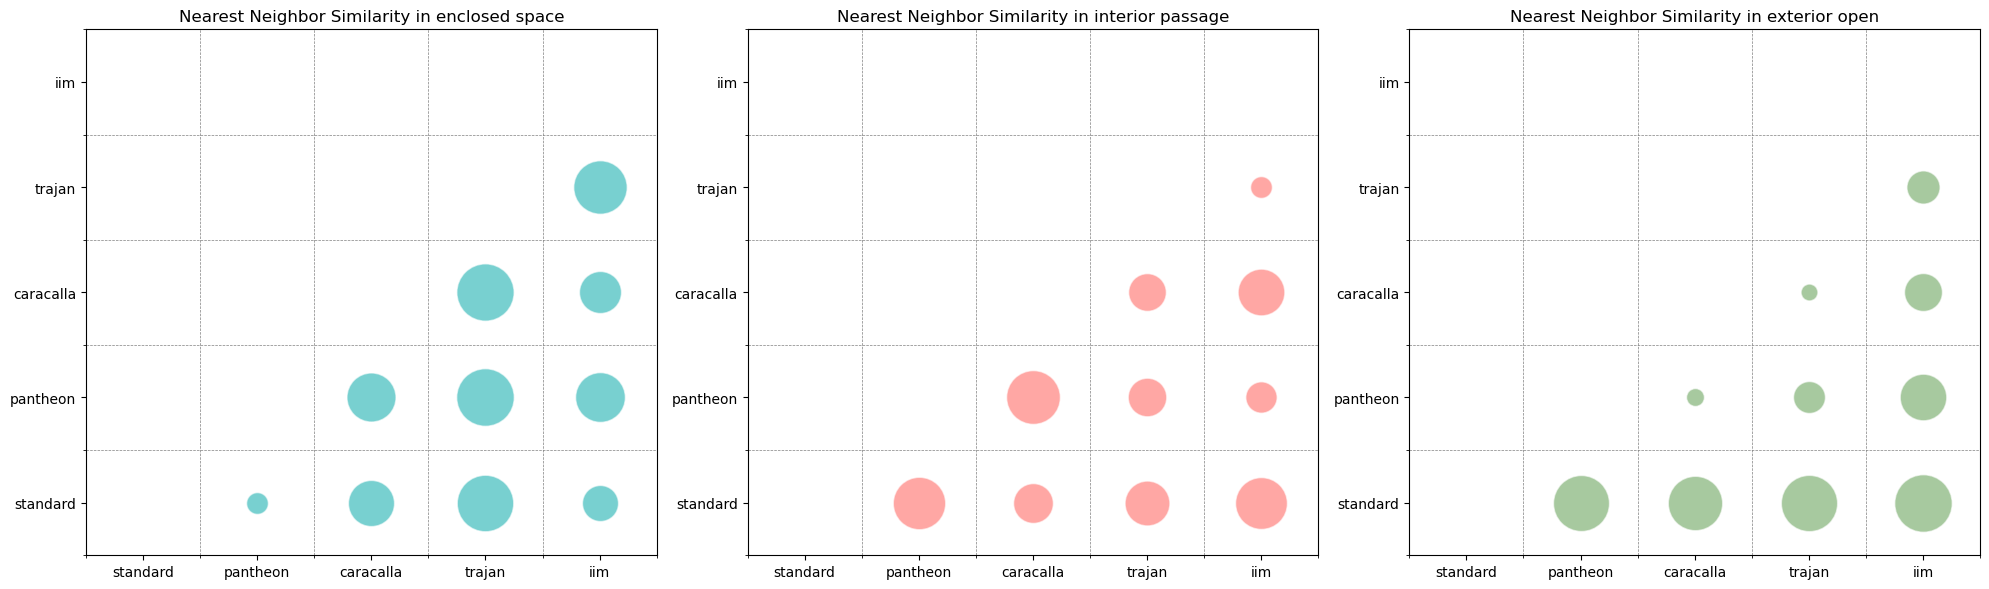

In [18]:
# Plotting heatmaps with circle sizes indicating similarity
colors = {
    "enclosed space": "#1fb2b2",
    "interior passage": "#ff6c68",
    "exterior open": "#6ca55f",
}
# Plotting the improved heatmaps with circles
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (space_type, matrix) in enumerate(similarity_matrices.items()):
    ax = axes[i]
    ax.set_title(f"Nearest Neighbor Similarity in {space_type}")
    ax.set_xticks(np.arange(len(building_names)))
    ax.set_yticks(np.arange(len(building_names)))
    ax.set_xticklabels(building_names)
    ax.set_yticklabels(building_names)
    ax.set_xlim(-0.5, len(building_names) - 0.5)
    ax.set_ylim(-0.5, len(building_names) - 0.5)

    # Draw the grid
    ax.grid(which="minor", color="gray", linestyle="--", linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, len(building_names), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(building_names), 1), minor=True)

    # Draw circles for the upper triangle
    for j in range(matrix.shape[0]):
        for k in range(j + 1, matrix.shape[1]):
            val = matrix[j, k]
            circle_size = val * 2000  # Adjust circle size scaling factor as needed
            ax.scatter(
                k, j, s=circle_size, color=colors[space_type], alpha=0.6, edgecolors="w"
            )

plt.tight_layout()
plt.show()

# TSNE

In [19]:
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px

colors = {
    "enclosed space": "#1fb2b2",
    "interior passage": "#ff6c68",
    "exterior open": "#6ca55f",
}
# Prepare data for tSNE
# Extract features and labels for t-SNE
features = np.array([item["feature"] for item in data])
building_types = [f"{item['bldg']}_{item['type']}" for item in data]
types = [item["type"] for item in data]

# Convert to numpy array
features = np.array(features).reshape(-1, 256)
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=22, perplexity=45)
tsne_results = tsne.fit_transform(features)


# Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(
    {
        "x": tsne_results[:, 0],
        "y": tsne_results[:, 1],
        "building_type": building_types,
        "type": types,
    }
)

# Create the figure using Plotly
fig = px.scatter(
    df_tsne,
    x="x",
    y="y",
    color="type",  # Use building_type as color
    labels={"color": "Building Type"},  # Rename legend title
    hover_name="building_type",  # Show building_type on hover
    color_discrete_map=colors,
)

# Update the layout to adjust the aspect ratio and remove legend title
fig.update_layout(
    width=1000,
    height=800,
    title="t-SNE Clustering of Building Spatial Sequences",
    plot_bgcolor="white",  # Set plot background to white
    xaxis=dict(showgrid=False),  # Remove x-axis grid lines
    yaxis=dict(showgrid=False),  # Remove y-axis grid lines
    xaxis_showticklabels=True,  # Optional: Display x-axis tick labels
    yaxis_showticklabels=True,  # Optional: Display y-axis tick labels
)
# Show the figure
fig.show()